In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import functions
from pyspark.sql.functions import to_date

def loadMovieNames():
    movieNames = {}
    with open("/home/maria_dev/TSR/u.item") as f:
        for line in f:
            fields = line.split('|')
            movieNames[int(fields[0])] = fields[1]
    return movieNames

# movieID = int(fields[0])
# movieTitle = fields[1]
# movieNames[movieID] = movieTitle

def parseInput(line):
    fields = line.split()
    return Row(movieID = int(fields[1]), rating = float(fields[2]), timestamp = int(fields[3]))

if __name__ == "__main__":
    # create a SparkSession
    spark = SparkSession.builder.appName("PopularMovies").getOrCreate()

    # load up our movie ID -> name dictionary
    movieNames = loadMovieNames()

    # convert movieNames dictionary to DataFrame
    movieNamesDF = spark.createDataFrame(list(movieNames.items()), ["movieID", "title"])

    # get the raw data
    lines = spark.sparkContext.textFile("hdfs:///user/maria_dev/ml-100k/u.data")
    # convert to RDD of Row objects with (movieID, rating)
    movies = lines.map(parseInput)
    # convert to DataFrame
    movieDataset = spark.createDataFrame(movies)

    # compute average rating for each movieID
    averageRatings = movieDataset.groupBy("movieID").avg("rating")

    # compute count of ratings for each movieID
    counts = movieDataset.groupBy("movieID").count()

    # compute oldest timestamp for each movieID
    oldTimestamp = movieDataset.groupBy("movieID").min("timestamp")

    # join the average ratings, counts & oldest timestamp
    averagesAndCounts = counts.join(averageRatings, "movieID")
    aRCoT = averagesAndCounts.join(oldTimestamp, "movieID")


    # filter to list movies with more than 100 ratings
    m100 = aRCoT.filter("count > 100")
    print("First 5 movies rated by more than 100 users")
    m100.show(n = 5)

    # put in the movie titles
    m100TD = movieNamesDF.join(m100, "movieID")
    print("First 5 movies with titles")
    m100TD.show(n = 5, truncate = False)

    # create list of movies with average rating of at least 3.5
    bestMovies = m100TD.filter(m100TD["avg(rating)"] >= 3.5)
    #bestMovies.show(n = 25, truncate = False)

    # create list of movies with average rating of less than 3.5
    worstMovies = m100TD.filter(m100TD["avg(rating)"] < 3.5)
    #worstMovies.show(n = 25, truncate = False)

    # sort the movies by ratings
    bestMovies = bestMovies.orderBy("avg(rating)",ascending = False)
    print("First 25 movies of best average ratings")
    bestMovies.show(n = 25, truncate = False)

    worstMovies = worstMovies.orderBy("avg(rating)")
    print("First 25 movies of worst average ratings")
    worstMovies.show(n = 25, truncate = False)

    # save each output list to single CSV file in hdfs
    #bestMovies.repartition(1).write.csv("hdfs:///user/maria_dev/ml-100k/P120754_best_movies.csv", header = True)
    #worstMovies.repartition(1).write.csv("hdfs:///user/maria_dev/ml-100k/P120754_worst_movies.csv", header = True)

    # select the top 25 results and displayed by oldest timestamp
    print("The best 25 movies by oldest timestamp")
    bestMovies.limit(25).orderBy("min(timestamp)").show(n = 25, truncate = False)
    print("The worst 25 movies by oldest timestamp")
    worstMovies.limit(25).orderBy("min(timestamp)").show(n = 25, truncate = False)

    # stop the session
    spark.stop()

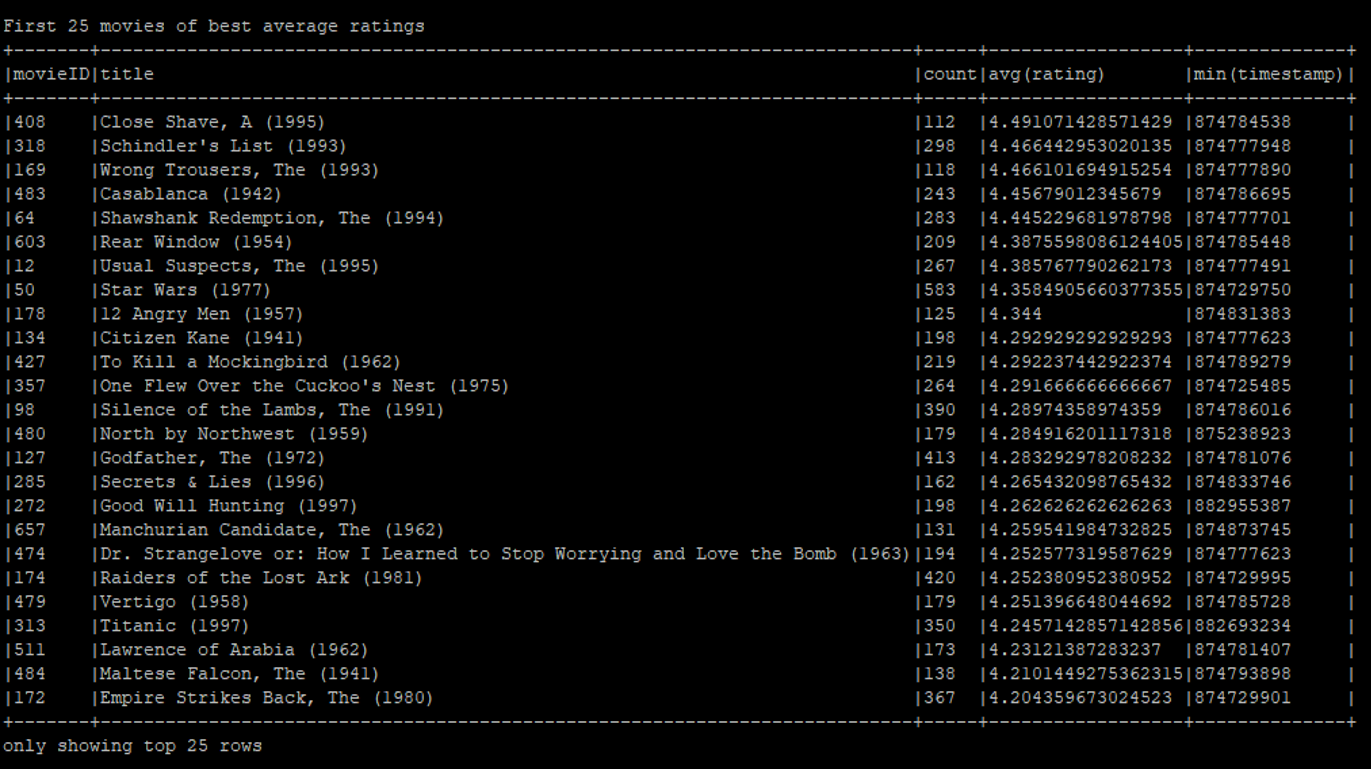

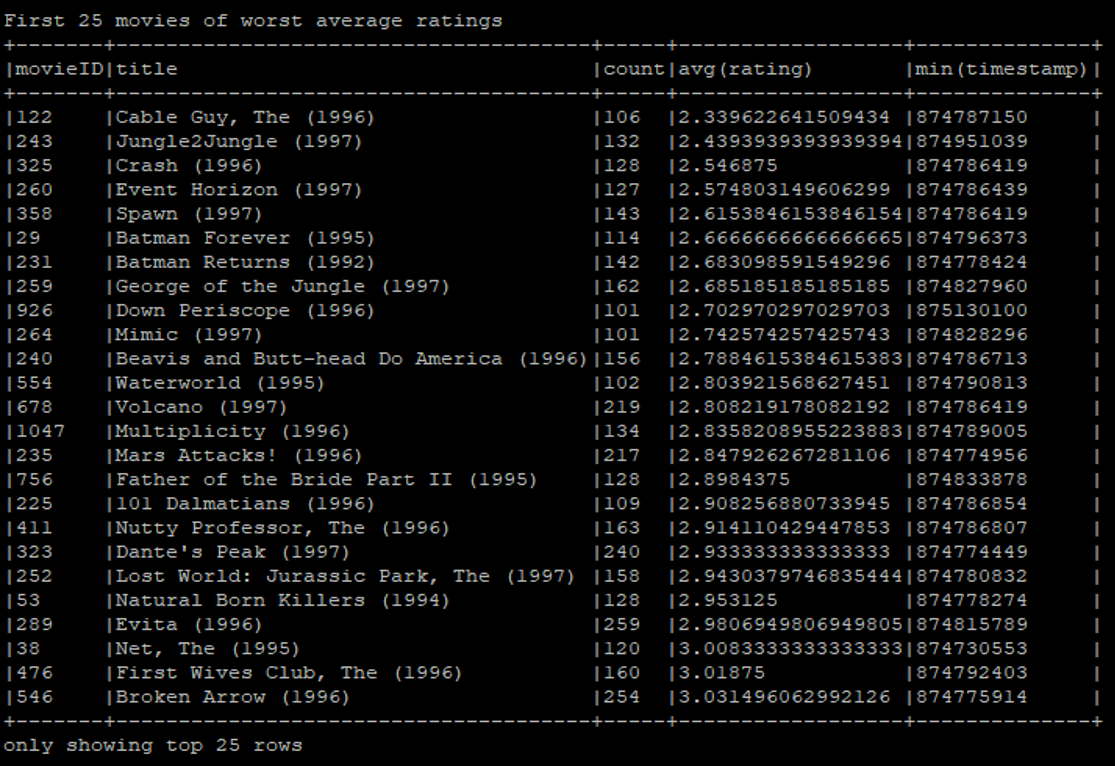

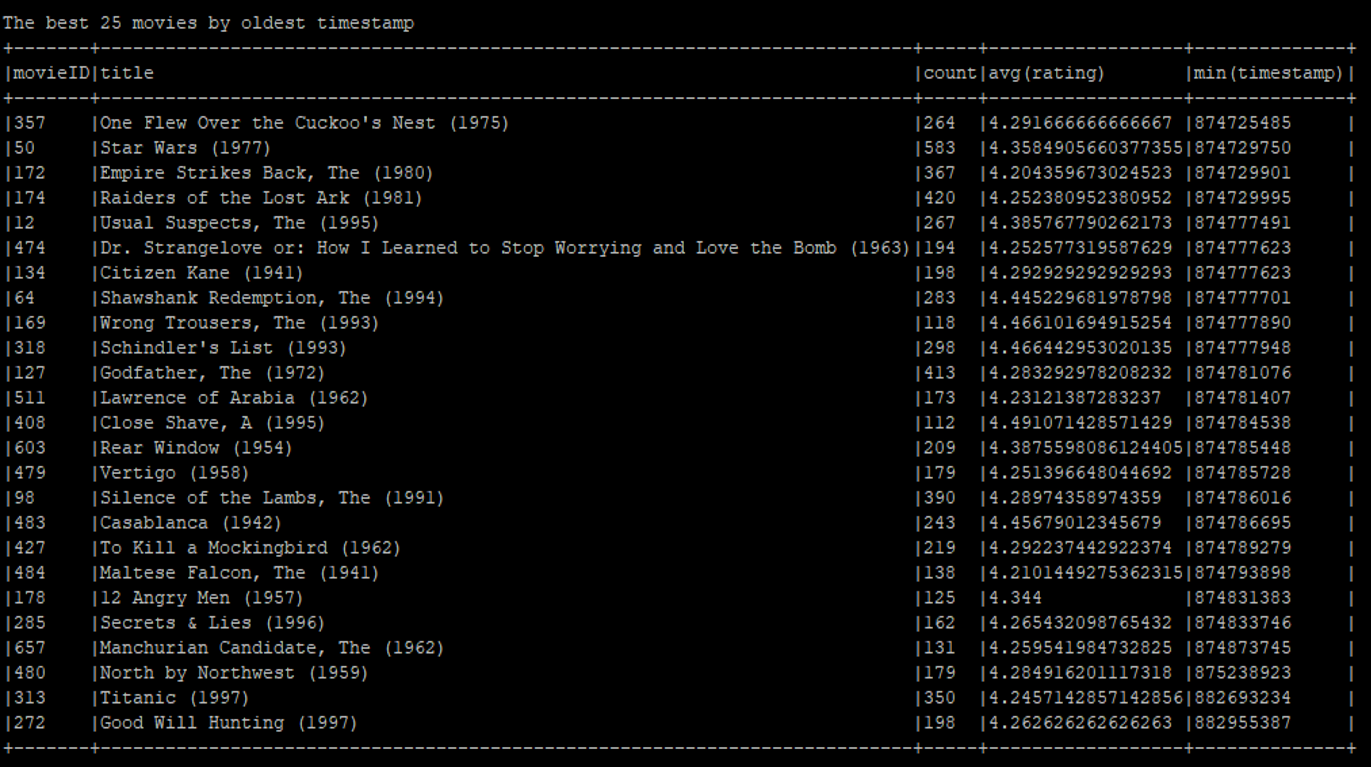

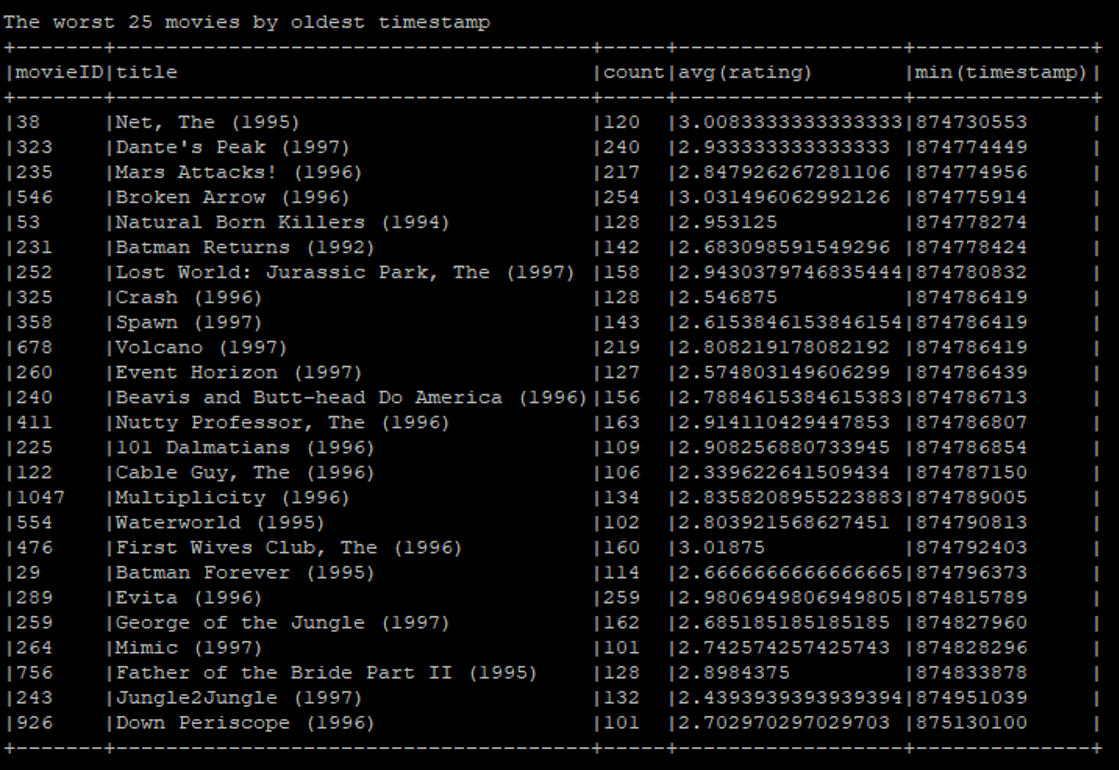